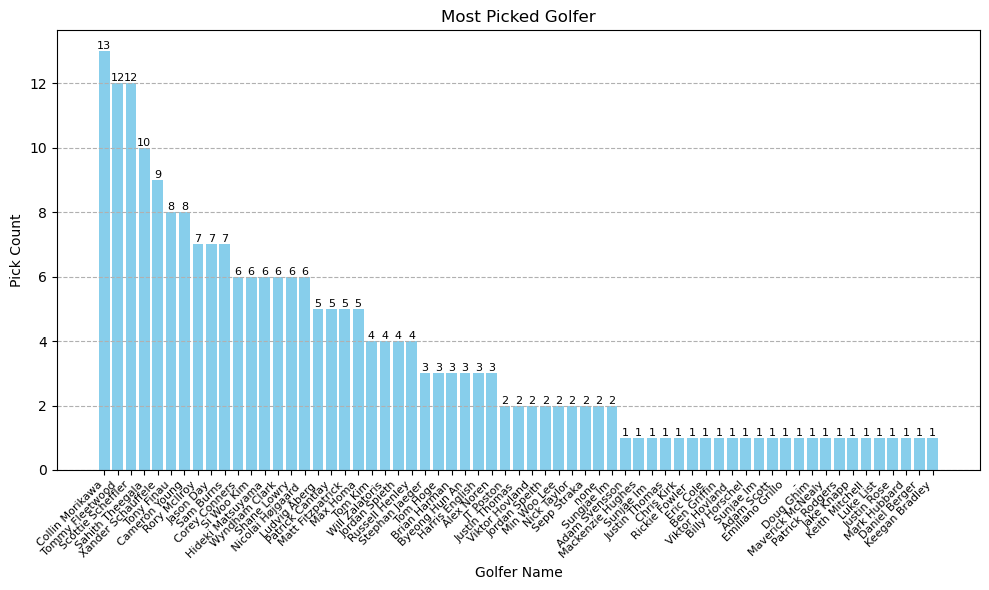

In [34]:
import tkinter as tk
from tkinter import ttk
import psycopg2
import pandas as pd
import sqlite3 
from tkinter import messagebox
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import matplotlib.pyplot as plt

# Read various files and creds, need to make these all into postgres queries
db_creds = pd.read_csv('/users/zack burnside/desktop/database_creds.csv')
tournament_data = pd.read_csv('/users/zack burnside/desktop/tournament_info.csv')
player_choice = pd.read_csv('/users/zack burnside/desktop/player_db.csv')
usernames = names = [
    "Z", "Timmy Chips", "Goob", "C", "Steve", "Sus", "DV3", "Jlo", 
    "Ty Dolla $$$", "Ryan", "Mike D", "Mando", "Eddie Buckets", "Garrett", "T Sully"
]

tournament_names = list(tournament_data['tournament_name'])
player_picks = list(player_choice['player_name'])
original_tournament_names = tournament_names.copy()
original_usernames = usernames.copy()
original_player_picks = player_picks.copy()

# updating the weekly_results table with updated data
def update_weekly_results():
    try:
        # Connect to the database
        conn = psycopg2.connect(
            dbname=db_creds['dbname'][0],
            user=db_creds['user'][0],
            password=db_creds['password'][0],
            host=db_creds['host'][0],
            port="5433"
        )
        cursor = conn.cursor()
        
        # SQL query to insert new data into weekly_results
        sql_query = """
            INSERT INTO public.weekly_results (tournament_name, user_name, prize_money, player_pick)
            SELECT DISTINCT
                up.tournament_name, 
                up.user_name, 
                tr.official_money AS prize_money,
                up.player_pick
            FROM 
                public.user_picks up
            JOIN 
                public.tournaments_results tr 
            ON 
                up.tournament_name = tr.tournament_name 
                AND up.player_pick = tr.player_name
            WHERE NOT EXISTS (
                SELECT 1 FROM public.weekly_results wr
                WHERE wr.tournament_name = up.tournament_name
                AND wr.user_name = up.user_name
                AND wr.player_pick = up.player_pick
            )
        """
        
        # Execute the SQL query
        cursor.execute(sql_query)
        
        # Commit the transaction
        conn.commit()
        print("Weekly results table updated successfully.")
        
    except psycopg2.Error as e:
        print(f"Error updating weekly results table: {e}")
        
    finally:
        # Close the cursor and connection
        cursor.close()
        conn.close()

# submit button for player pick entry
def submit():
    user_name = user_name_var.get()
    tournament_name = tournament_name_var.get()
    player_pick = player_pick_var.get()
    date = None
    
    # Connect to postgres DB
    conn = psycopg2.connect(
        dbname=db_creds['dbname'][0],
        user=db_creds['user'][0],
        password=db_creds['password'][0],
        host=db_creds['host'][0],
        port="5433"
    )
    c = conn.cursor()
    
    # Check if the player has been previously picked by the user
    c.execute('''SELECT player_pick FROM user_picks WHERE user_name = %s''', (user_name,))
    previous_picks = c.fetchall()
    previous_picks = [pick[0] for pick in previous_picks]
    
    if player_pick in previous_picks:
        messagebox.showinfo("Error", "You have already picked this player. Please choose a different player.")
        conn.close()
        return
    
    c.execute('''SELECT tournament_name FROM user_picks WHERE user_name = %s''', (user_name,))
    tournament_picks = c.fetchall()
    tournament_picks = [pick[0] for pick in tournament_picks]

    if tournament_name in tournament_picks:
        messagebox.showinfo("Error", "That Tournament already happened. Please choose a different tournament.")
        conn.close()
        return

    # Insert data into postgres db
    c.execute('''INSERT INTO public.user_picks (tournament_name, user_name, date, player_pick)
                 VALUES (%s, %s, %s, %s)''', (tournament_name, user_name, date, player_pick))
    
    print({'Username': user_name, 'Tournament Name': tournament_name, 'Player Pick': player_pick})
    
    conn.commit()
    conn.close()

# opening the results window for previous results
def open_past_results_window():
    past_results_window = tk.Toplevel(root)
    past_results_window.title("Past Results")

    tournament_names = get_unique_tournament_names()

    for i, tournament_name in enumerate(tournament_names):
        button = tk.Button(past_results_window, text=tournament_name, command=lambda name=tournament_name: show_tournament_results(name), bg="green", fg="white")
        button.grid(row=i, column=0, pady=5)
# Show standings button

def get_standings():
    conn = psycopg2.connect(
        dbname=db_creds['dbname'][0],
        user=db_creds['user'][0],
        password=db_creds['password'][0],
        host=db_creds['host'][0],
        port="5433"
    )
    cursor = conn.cursor()
    cursor.execute("SELECT DISTINCT user_name, SUM(prize_money::numeric) AS total_prize_money FROM public.weekly GROUP BY user_name ORDER BY total_prize_money DESC")
    rows = cursor.fetchall()
    conn.close()
    
    # Format the prize money as dollars
    formatted_rows = [(row[0], "${:,.2f}".format(row[1])) for row in rows]
    return formatted_rows
def show_standings():
    # Replace with your actual logic to fetch standings data from database
    standings_data = get_standings()

    standings_frame = ttk.Frame(root)
    standings_frame.grid(row=10, column=0, columnspan=2, padx=10, pady=10, sticky="nsew")

    tree = ttk.Treeview(standings_frame, columns=("User Name", "Total Money"), show="headings")
    tree.heading("User Name", text="User Name")
    tree.heading("Total Money", text="Total Money")
    tree.pack()

    for row in standings_data:
        tree.insert("", "end", values=row)
# Drop down menu filtering
def filter_dropdown(event):
    current_text = event.widget.get().strip().lower()  # Strip whitespace and convert to lowercase
    if event.widget == tournament_name_dropdown:
        full_values = original_tournament_names
    elif event.widget == player_pick_dropdown:
        full_values = original_player_picks
    else:
        full_values = original_usernames
    
    filtered_values = [value for value in full_values if current_text in value.lower()]
    if not filtered_values:
        event.widget['values'] = full_values  # Set full values if no match found
    else:
        event.widget['values'] = filtered_values

# Tournament info button
def tournament_info():
    conn = psycopg2.connect(
        dbname=db_creds['dbname'][0],
        user=db_creds['user'][0],
        password=db_creds['password'][0],
        host=db_creds['host'][0],
        port="5433"
    )

    info_window = tk.Toplevel()
    info_window.title("Tournament Info")
    
    table_frame = ttk.Frame(info_window)
    table_frame.pack(pady=10)

    cursor = conn.cursor()
    cursor.execute("SELECT * FROM public.tournament_info")
    data = cursor.fetchall()

    tree = ttk.Treeview(table_frame, columns=("Tournament Number", "Tournament Name", "Dates", "Purse"), show="headings")
    tree.heading("Tournament Number", text="Tournament Number")
    tree.heading("Tournament Name", text="Tournament Name")
    tree.heading("Dates", text="Dates")
    tree.heading("Purse", text="Purse")
    tree.pack()

    for row in data:
        tree.insert("", "end", values=row)
    
    conn.close()
    info_window.mainloop()

# Past result functions
def get_unique_tournament_names():
    conn = psycopg2.connect(
        dbname=db_creds['dbname'][0],
        user=db_creds['user'][0],
        password=db_creds['password'][0],
        host=db_creds['host'][0],
        port="5433"
    )
    cursor = conn.cursor()
    cursor.execute("SELECT DISTINCT(tournament_name) FROM public.tournaments_results")
    tournament_names = [row[0] for row in cursor.fetchall()]
    conn.close()
    return tournament_names
def show_tournament_results(tournament_name):
    conn = psycopg2.connect(
        dbname=db_creds['dbname'][0],
        user=db_creds['user'][0],
        password=db_creds['password'][0],
        host=db_creds['host'][0],
        port="5433"
    )
    cursor = conn.cursor()
    cursor.execute("""
        SELECT user_name, player_pick, prize_money 
        FROM public.weekly_results 
        WHERE tournament_name = %s
    """, (tournament_name,))
    data = cursor.fetchall()

    # Creating the new window
    results_window = tk.Toplevel()
    results_window.title(f"Tournament Results: {tournament_name}")

    # Creating a table to display the data
    table_frame = ttk.Frame(results_window)
    table_frame.pack(padx=10, pady=10)

    tree = ttk.Treeview(table_frame, columns=("User Name", "Player Pick", "Prize Money"), show="headings")
    tree.heading("User Name", text="User Name")
    tree.heading("Player Pick", text="Player Pick")
    tree.heading("Prize Money", text="Prize Money")
    tree.pack()

    for row in data:
        tree.insert("", "end", values=row)

    conn.close()

def create_tournament_buttons(root, tournament_names):
    for i, tournament_name in enumerate(tournament_names):
        button = tk.Button(root, text=tournament_name, command=lambda name=tournament_name: show_tournament_results(tournament_name), bg="green", fg="white")
        button.grid(row=3 + i, column=5, pady=5)
# Stats page
def show_stats_page():
    stats_window = tk.Toplevel(root)
    stats_window.title("Statistics")
    
    frame = ttk.Frame(stats_window)
    frame.pack(padx=10, pady=10)
    
    highest_avg_button = tk.Button(frame, text="Highest Avg", command=show_highest_avg, bg="orange", fg="black")
    highest_avg_button.grid(row=0, column=0, padx=5, pady=5)

    most_picked_golfer_button = tk.Button(frame, text="Most Picked Golfer", command=show_most_picked_golfer, bg="orange", fg="black")
    most_picked_golfer_button.grid(row=0, column=1, padx=5, pady=5)
    
    correct_button = tk.Button(frame, text="Show Correct Picks", command=show_correct_picks, bg="orange", fg="black")
    correct_button.grid(row=0, column=2, padx=5, pady=5)

# Function to show the highest average
def show_highest_avg():
    conn = psycopg2.connect(
        dbname=db_creds['dbname'][0],
        user=db_creds['user'][0],
        password=db_creds['password'][0],
        host=db_creds['host'][0],
        port="5433"
    )
    cursor = conn.cursor()
    cursor.execute("SELECT user_name, AVG(prize_money::NUMERIC) AS avg_money FROM public.weekly_results GROUP BY user_name ORDER BY avg_money DESC;")
    data = cursor.fetchall()
    conn.close()

    users = [row[0] for row in data]
    avg_money = [row[1] for row in data]

    chart_window = tk.Toplevel()
    chart_window.title("Highest Average Money")
    fig, ax = plt.subplots(figsize=(10, 6))
    bars = ax.bar(users, avg_money, color='skyblue')

    for bar in bars:
        avg_value = bar.get_height()
        formatted_avg = '{:,.2f}'.format(round(avg_value))
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), formatted_avg, ha='center', va='bottom', fontsize=8)

    ax.set_title('Highest Average Money by User', fontsize=12)
    ax.set_xlabel('User Name', fontsize=10)
    ax.set_ylabel('Average Money', fontsize=10)
    plt.xticks(rotation=45, ha='right', fontsize=8)
    plt.grid(axis='y', linestyle='--')
    plt.tight_layout()

    canvas = FigureCanvasTkAgg(fig, master=chart_window)
    canvas.draw()
    canvas.get_tk_widget().pack()

    chart_window.mainloop()
# Function to show the most picked golfer
def show_most_picked_golfer():
    conn = psycopg2.connect(
        dbname=db_creds['dbname'][0],
        user=db_creds['user'][0],
        password=db_creds['password'][0],
        host=db_creds['host'][0],
        port="5433"
    )
    cursor = conn.cursor()
    cursor.execute("SELECT player_pick, COUNT(*) as pick_count FROM public.user_picks GROUP BY player_pick ORDER BY pick_count DESC")
    data = cursor.fetchall()
    conn.close()

    golfers = [row[0] for row in data]
    pick_count = [row[1] for row in data]

    chart_window = tk.Toplevel()
    chart_window.title("Most Picked Golfer")
    fig, ax = plt.subplots(figsize=(10, 6))
    bars = ax.bar(golfers, pick_count, color='skyblue')

    for bar in bars:
        count_value = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(count_value), ha='center', va='bottom', fontsize=8)

    ax.set_title('Most Picked Golfer', fontsize=12)
    ax.set_xlabel('Golfer Name', fontsize=10)
    ax.set_ylabel('Pick Count', fontsize=10)
    plt.xticks(rotation=45, ha='right', fontsize=8)
    plt.grid(axis='y', linestyle='--')
    plt.tight_layout()

    canvas = FigureCanvasTkAgg(fig, master=chart_window)
    canvas.draw()
    canvas.get_tk_widget().pack()

    chart_window.mainloop()
def show_correct_picks():
    conn = psycopg2.connect(
        dbname=db_creds['dbname'][0],
        user=db_creds['user'][0],
        password=db_creds['password'][0],
        host=db_creds['host'][0],
        port="5433"
    )
    cursor = conn.cursor()
    query = """
        SELECT 
        up.user_name, 
        COUNT(*) AS correct_picks
    FROM 
        public.user_picks up
    JOIN 
        (SELECT 
            tr.tournament_name, 
            tr.player_name AS winner
        FROM 
            public.tournaments_results tr
        JOIN 
            (SELECT 
                tournament_name, 
                MAX(official_money) AS max_prize_money
            FROM 
                public.tournaments_results
            GROUP BY 
                tournament_name
            ) subquery
        ON 
            tr.tournament_name = subquery.tournament_name 
            AND tr.official_money = subquery.max_prize_money
        ) winners
    ON 
        up.tournament_name = winners.tournament_name 
        AND up.player_pick = winners.winner
    GROUP BY 
        up.user_name
    ORDER BY 
        correct_picks DESC;
    """
    cursor.execute(query)
    rows = cursor.fetchall()
    conn.close()
    
    # Create a new window for stats
    stats_window = tk.Toplevel()
    stats_window.title("Correct Picks by Users")

    # Create a Treeview widget to display the results
    tree = ttk.Treeview(stats_window, columns=("User Name", "Correct Picks"), show="headings")
    tree.heading("User Name", text="User Name")
    tree.heading("Correct Picks", text="Correct Picks")
    tree.pack(fill=tk.BOTH, expand=True)

    # Insert the query results into the Treeview
    for row in rows:
        tree.insert("", "end", values=row)

    stats_window.mainloop()

root = tk.Tk()
root.title("PGA Pool Picker")
root.geometry('1200x1000')

# Styles
style = ttk.Style()
style.theme_use('vista')

# Header label
header_label = ttk.Label(root, text="PGA Pool Picker", font=('Arial', 24, 'bold'))
header_label.grid(row=0, column=0, columnspan=3, pady=20)

# Labels and Comboboxes
labels = ["User Name:", "Tournament Name:", "Player Pick:"]
for i, label_text in enumerate(labels):
    label = ttk.Label(root, text=label_text, font=('Arial', 12))
    label.grid(row=i+1, column=0, padx=10, pady=5, sticky='e')

user_name_var = tk.StringVar()
user_name_dropdown = ttk.Combobox(root, textvariable=user_name_var, values=original_usernames, font=('Arial', 12))
user_name_dropdown.grid(row=1, column=1, padx=10, pady=5)

tournament_name_var = tk.StringVar()
tournament_name_dropdown = ttk.Combobox(root, textvariable=tournament_name_var, values=original_tournament_names, font=('Arial', 12))
tournament_name_dropdown.grid(row=2, column=1, padx=10, pady=5)

player_pick_var = tk.StringVar()
player_pick_dropdown = ttk.Combobox(root, textvariable=player_pick_var, values=original_player_picks, font=('Arial', 12))
player_pick_dropdown.grid(row=3, column=1, padx=10, pady=5)

# Submit button
submit_button = tk.Button(root, text="Submit", command=submit, bg="blue", fg="white", font=('Arial', 12, 'bold'))
submit_button.grid(row=4, column=1, columnspan=2, pady=20)

# Stats page button
stats_button = tk.Button(root, text="Show Stats", command=show_stats_page, bg="green", fg="white", font=('Arial', 12, 'bold'))
stats_button.grid(row=1, column=5, padx=(0, 20), pady=10)

# Past results button
past_results_button = tk.Button(root, text='Past Results', command=open_past_results_window, bg="green", fg="white", font=('Arial', 12, 'bold'))
past_results_button.grid(row=2, column=5, padx=(0, 20), pady=10)

# Tournament info button
tournament_info_button = tk.Button(root, text="Tournament Info", command=tournament_info, bg="green", fg="white", font=('Arial', 12, 'bold'))
tournament_info_button.grid(row=3, column=5, padx=(0, 20), pady=10)

# Footer label
footer_label = ttk.Label(root, text="© 2024 PGA Pool Picker. All rights reserved.", font=('Arial', 10))
footer_label.grid(row=50, column=0, columnspan=10, pady=20)

tournament_name_dropdown.bind("<KeyRelease>", filter_dropdown)
player_pick_dropdown.bind("<KeyRelease>", filter_dropdown)


show_standings()

root.mainloop()
